In [2]:
import pickle
import os

file_X = 'X_data.pkl'
file_y = 'y_data.pkl'

if not os.path.exists(file_X) or not os.path.exists(file_y):
    with open(file_X, 'wb') as f:
        pickle.dump(X_master, f)
    with open(file_y, 'wb') as f:
        pickle.dump(y_master, f)
    print(f"Data has been saved to {file_X} and {file_y}")
else:
    # If the files exist, load X and y from the pickle files
    with open(file_X, 'rb') as f:
        X = pickle.load(f)
    with open(file_y, 'rb') as f:
        y = pickle.load(f)
    print("Data has been loaded from existing pickle files.")




Data has been loaded from existing pickle files.


In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy.stats import kurtosis, skew
from pywt import wavedec

eeg_data = X

# Feature Extraction Functions
def extract_time_domain_features(signal):
    """Extract basic statistical features."""
    return {
        'mean': np.mean(signal),
        'variance': np.var(signal),
        'std_dev': np.std(signal),
        'skewness': skew(signal),
        'kurtosis': kurtosis(signal),
        'entropy': -np.sum(signal * np.log2(np.abs(signal) + 1e-10)),
        'zero_crossings': np.sum(np.diff(np.sign(signal)) != 0)
    }

def extract_frequency_domain_features(signal, sf=256, band_limits=[(0.5, 4), (4, 8), (8, 12), (12, 30), (30, 45)]):
    """Extract frequency features using Welch's method."""
    features = {}
    freqs, psd = welch(signal, sf, nperseg=1024)
    total_power = np.sum(psd)
    
    for i, (low, high) in enumerate(band_limits):
        band_power = np.sum(psd[(freqs >= low) & (freqs < high)])
        features[f'band_{i}_power'] = band_power
        features[f'band_{i}_relative_power'] = band_power / total_power
    
    return features

def extract_wavelet_features(signal, wavelet='db4', level=4):
    """Extract wavelet coefficients."""
    coeffs = wavedec(signal, wavelet, level=level)
    features = {}
    for i, coeff in enumerate(coeffs):
        features[f'wavelet_{i}_mean'] = np.mean(coeff)
        features[f'wavelet_{i}_variance'] = np.var(coeff)
    return features

# Process Each Channel
extracted_features = []
for index, row in eeg_data.iterrows():
    row_features = {}
    signal = row.values
    
    # Time-Domain Features
    row_features.update(extract_time_domain_features(signal))
    
    # Frequency-Domain Features
    row_features.update(extract_frequency_domain_features(signal))
    
    # Wavelet Features
    row_features.update(extract_wavelet_features(signal))
    
    extracted_features.append(row_features)

features_df = pd.DataFrame(extracted_features)

features_df.to_csv('eeg_features.csv', index=False)

print("Feature extraction completed. Features saved to 'eeg_features.csv'.")


Feature extraction completed. Features saved to 'eeg_features.csv'.


c:\Users\mridu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test Accuracy: 0.8192
              precision    recall  f1-score   support

         GPD       0.94      0.81      0.87       200
        GRDA       0.81      0.84      0.83       200
         LPD       0.82      0.83      0.83       200
        LRDA       0.95      0.92      0.94       200
       Other       0.76      0.71      0.74       200
     Seizure       0.67      0.80      0.73       200

    accuracy                           0.82      1200
   macro avg       0.83      0.82      0.82      1200
weighted avg       0.83      0.82      0.82      1200



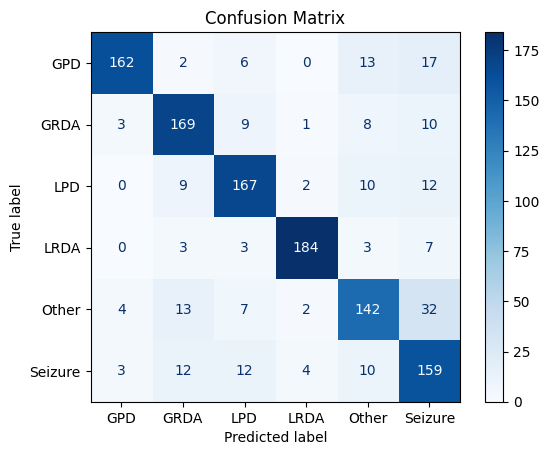

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score,  confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer


data = pd.read_csv('eeg_features.csv')

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(data)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # This will transform string labels to numerical values

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 13, 'n_estimators': 1537}
forest = RandomForestClassifier(n_estimators=1000,max_depth=10,min_samples_leaf=2,min_samples_split=13,max_features='sqrt', random_state=42)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"test Accuracy: {accuracy:.4f}")

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Accuracy: 0.885

Classification Report:
               precision    recall  f1-score   support

         GPD       0.91      0.94      0.93       200
        GRDA       0.82      0.96      0.89       200
         LPD       0.92      0.92      0.92       200
        LRDA       0.93      0.98      0.95       200
       Other       0.87      0.70      0.78       200
     Seizure       0.87      0.80      0.84       200

    accuracy                           0.89      1200
   macro avg       0.89      0.88      0.88      1200
weighted avg       0.89      0.89      0.88      1200



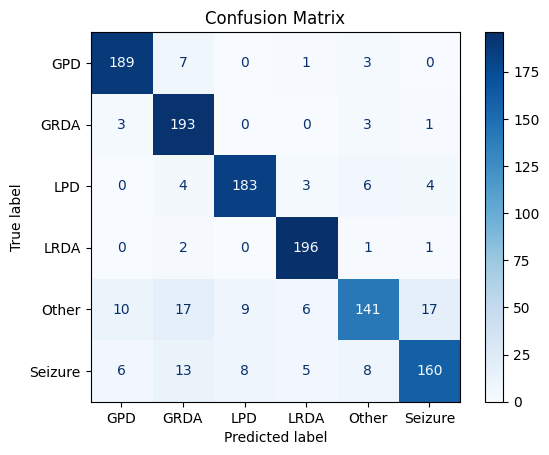

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),  # Three hidden layers with respective neurons
    activation='relu',                # Activation function
    solver='adam',                    # Optimization algorithm
    alpha=0.0001,                     # L2 regularization (default)
    batch_size=32,                    # Mini-batch size
    learning_rate='adaptive',         # Learning rate adjustment
    max_iter=300,                     # Maximum number of iterations
    random_state=42
)


mlp.fit(X_train_scaled, y_train)


y_pred = mlp.predict(X_test_scaled)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(128, 64, 32), (256, 128, 64), (128, 128, 128)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'batch_size': [16, 32, 64],
    'learning_rate': ['adaptive', 'constant'],
    'max_iter': [300, 500],
}

grid_search = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=3,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


Test Accuracy
Accuracy: 0.905

Classification Report:
               precision    recall  f1-score   support

         GPD       0.93      0.96      0.95       200
        GRDA       0.89      0.94      0.92       200
         LPD       0.93      0.94      0.94       200
        LRDA       0.94      0.94      0.94       200
       Other       0.82      0.81      0.82       200
     Seizure       0.93      0.82      0.87       200

    accuracy                           0.91      1200
   macro avg       0.91      0.90      0.90      1200
weighted avg       0.91      0.91      0.90      1200



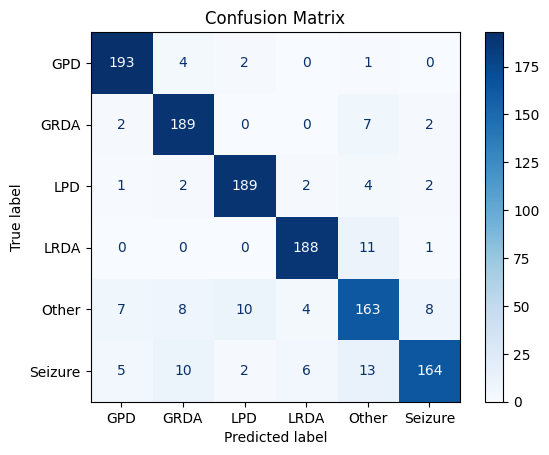

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report



svm = SVC(
    kernel='rbf',             # Radial basis function kernel
    C=100,                    # Regularization parameter
    gamma=1,            # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    random_state=42           # Ensures reproducibility
)

# Fit the model
svm.fit(X_train_scaled, y_train)

print("Test Accuracy")
y_pred = svm.predict(X_test_scaled)

# Print accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()





In [ ]:
from sklearn.svm import SVC


svm = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],           # Regularization parameter
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'linear', 'poly'],  # Kernels to test
}

# --- Apply GridSearchCV ---
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='accuracy',      # Metric to optimize
    cv=5,                    # 5-fold cross-validation
    verbose=3,               # Print progress
    n_jobs=-1                # Use all processors
)

grid_search.fit(X_train_scaled, y_train)

# --- Best Parameters and Model Evaluation ---
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_scaled)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))




Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.8608333333333332

Test Accuracy: 0.905

Classification Report:
               precision    recall  f1-score   support

         GPD       0.93      0.96      0.95       200
        GRDA       0.89      0.94      0.92       200
         LPD       0.93      0.94      0.94       200
        LRDA       0.94      0.94      0.94       200
       Other       0.82      0.81      0.82       200
     Seizure       0.93      0.82      0.87       200

    accuracy                           0.91      1200
   macro avg       0.91      0.90      0.90      1200
weighted avg       0.91      0.91      0.90      1200

